In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

# Wczytywanie danych

### Ceny

Ceny z https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce.
Okres: 2023-07-01 - 2024-07-31, krok - 1 godzina. Wybrałam lipiec, żeby fotowoltaika produkowałą więcej energii.

In [2]:
prices = pd.read_csv("data\\prices\\ceny_lipiec.csv", delimiter=';', decimal=',')

In [3]:
prices.Godzina = prices.Godzina - 1  # dodawać 1 dzień do daty
prices['dt'] = prices.Data * 100 + prices.Godzina
prices.dt = pd.to_datetime(prices.dt, format='%Y%m%d%H')
prices = prices.drop(columns=['Data', 'Godzina'])
prices.RCE = prices.RCE / 1000

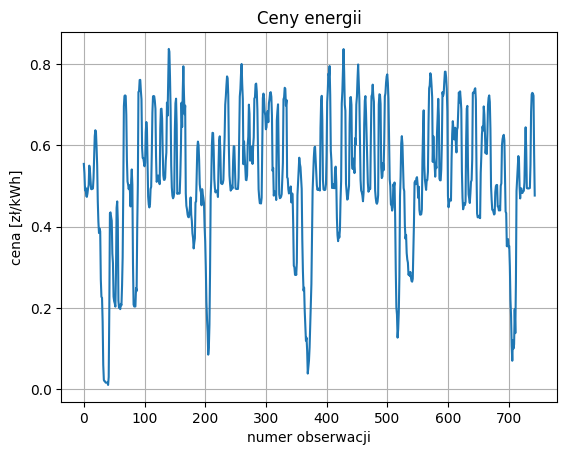

In [4]:
_ = prices.RCE.plot(grid=True, xlabel='numer obserwacji', ylabel='cena [zł/kWh]', title='Ceny energii')

Ceny są okresowe, więc przybliżam je dwoma sinusami, jeden odpowiada za tygodnie, drugi za dni.

### Energia

Dane z solcast.com dla Wrocławia. Okres: 2023-07-01 - 2023-07-01, krok - 1 godzina.

GHI - całkowite natężenie promieniowania słonecznego na poziomej powierzchni Ziemi. Jest to suma bezpośredniego napromieniowania (po uwzględnieniu kąta zenitalnego Słońca z) i rozproszonego poziomego napromieniowania.
Pobrałam ghi dlatego, że dane o ilości produkowanej energii są płatne.

In [49]:
ghi = pd.read_csv('data\\solar_stuff\\solar_short.csv', usecols=['ghi', 'period_end'])
ghi.period_end = pd.to_datetime(ghi.period_end)

In [50]:
ghi = ghi[(ghi.period_end >= "2023-07-01") & (ghi.period_end <= "2023-07-31")]
ghi = ghi.reset_index()
ghi.ghi = ghi.ghi / 1000

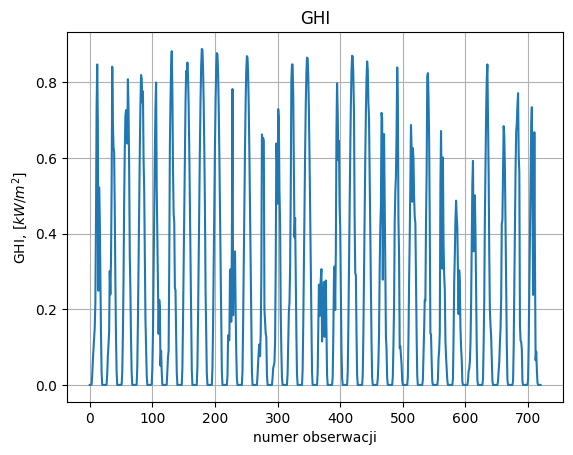

In [52]:
_ = ghi.ghi.plot(title="GHI", grid=True, xlabel="numer obserwacji", ylabel="GHI, [$kW/m^2$]")

Dane okresowe, ale tylko dzienna, więc przybliżam jednym sinusem.

# Dobór funkcji

In [8]:
test_date = '2023-07-14'

### Ceny

In [9]:
prices_train = prices[prices.dt < test_date]

In [10]:
def _price_func(x, a, b, c, d, e, f, g):
    return a * np.sin(b * (2 * np.pi) * x + c) + \
        d * np.sin(2 * np.pi * e * x + f) + g

In [11]:
price_params = scipy.optimize.curve_fit(_price_func, prices_train.index, prices_train.RCE,
                                        p0=[prices_train.std().iloc[0],
                                            1 / (7 * 24),
                                            1,
                                            prices_train.std().iloc[0],
                                            1 / 24,
                                            1,
                                            prices_train.mean().iloc[0]])

In [12]:
price_params[0]

array([-0.14054548,  0.00649954, -0.30069391,  0.10091864,  0.04222861,
        1.8244978 ,  0.51070261])

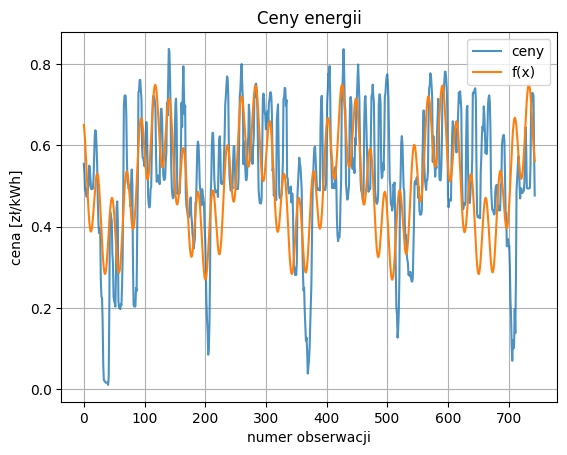

In [13]:
_ = prices.RCE.plot(grid=True, xlabel='numer obserwacji', ylabel='cena [zł/kWh]', title='Ceny energii', alpha=0.8)
_ = plt.plot(prices.index, _price_func(prices.index, *price_params[0]), c='C1', alpha=1)
_ = plt.legend(['ceny', 'f(x)'])

In [14]:
print('{}sin(2pi{}x + {}) + {}sin(2pi{}x + {}) + {}'.
      format(*[np.round(param, 3) for param in price_params[0]]))

-0.141sin(2pi0.006x + -0.301) + 0.101sin(2pi0.042x + 1.824) + 0.511


1/0.042 = 23.8 - prawie doba, 1/0.006 = 167 = 6.9 * 24 - prawie tydzień.

In [43]:
price_func = lambda x: _price_func(x, *price_params[0])

### Energia

In [54]:
area = 1 * 1.65
efficiency = 0.2
ghi["energy"] = ghi.ghi * area * efficiency

In [55]:
def _energy_func(x, a, b, c):
    temp = a * np.sin(2 * np.pi * b * x + c)
    return [t if t > 0 else 0 for t in temp]

In [56]:
energy_params = scipy.optimize.curve_fit(_energy_func, ghi.index, ghi.energy,
                                         p0=[ghi.energy.std(),
                                             1 / 24,
                                             1])

In [57]:
energy_params[0]

array([ 0.2296899 ,  0.04169158, -1.48736615])

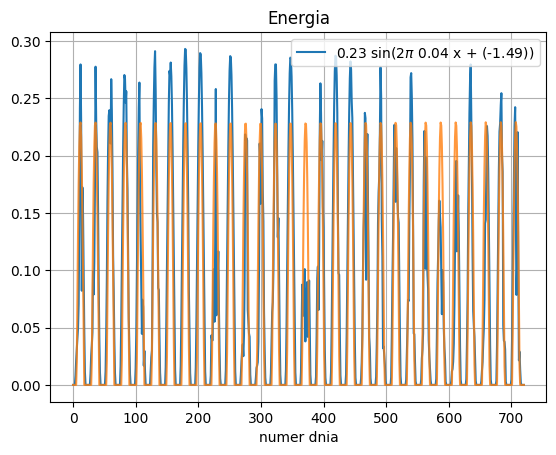

In [58]:
_ = ghi.energy.plot(title="Energia", xlabel="numer dnia", grid=True)
_ = plt.plot(ghi.index, _energy_func(ghi.index, *energy_params[0]), c='C1', alpha=0.8)
_ = plt.legend(['{} sin(2$\pi$ {} x + ({}))'.
               format(*[np.round(param, 2) for param in energy_params[0]])])

In [59]:
energy_func = lambda x: _energy_func(x, *energy_params[0])

### Zapotrzebowanie

In [60]:
from demand import demand, step_demand

# Parametry

In [64]:
Rc = 20  # the energy capacity in kWh
nc = 0.8  # the charging efficiency of the device
nd = 0.8  # the discharging efficiency of the device
gc = Rc / 5  # the max charging rate of the device [kWh per hour] - żeby ładował się 5 godzin
gd = Rc / 5  # the max discharging rate of the device [kWh per hour]

Niech firma ma 40 paneli solarnych.

In [65]:
N = 40

In [28]:
dates = prices[prices.dt >= test_date].dt.reset_index(drop=True)
t = np.arange(len(dates))

phi = np.array([0, 0, -1, nc, nc, -1]) # przejście ze stanu magazynu w t-1 do t

# Rozwiązanie

In [30]:
from solver import solve

### Zerowe zapotrzebowanie roczne

Firma nie ma własnego zapotrzebowania, ma panele fotowoltaiczne i tylko kupuje/sprzedaje energię.

In [119]:
annual_demand = 0

In [120]:
S = pd.DataFrame({"P": price_func(t),
                  "D": demand(t, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})
S.E = N * S.E # bo 40 paneli

In [121]:
xs = solve(S, Rc, nc, nd, gc, gd)

In [122]:
S.R = xs.cumsum().dot(phi) # wektor stanów magazynu

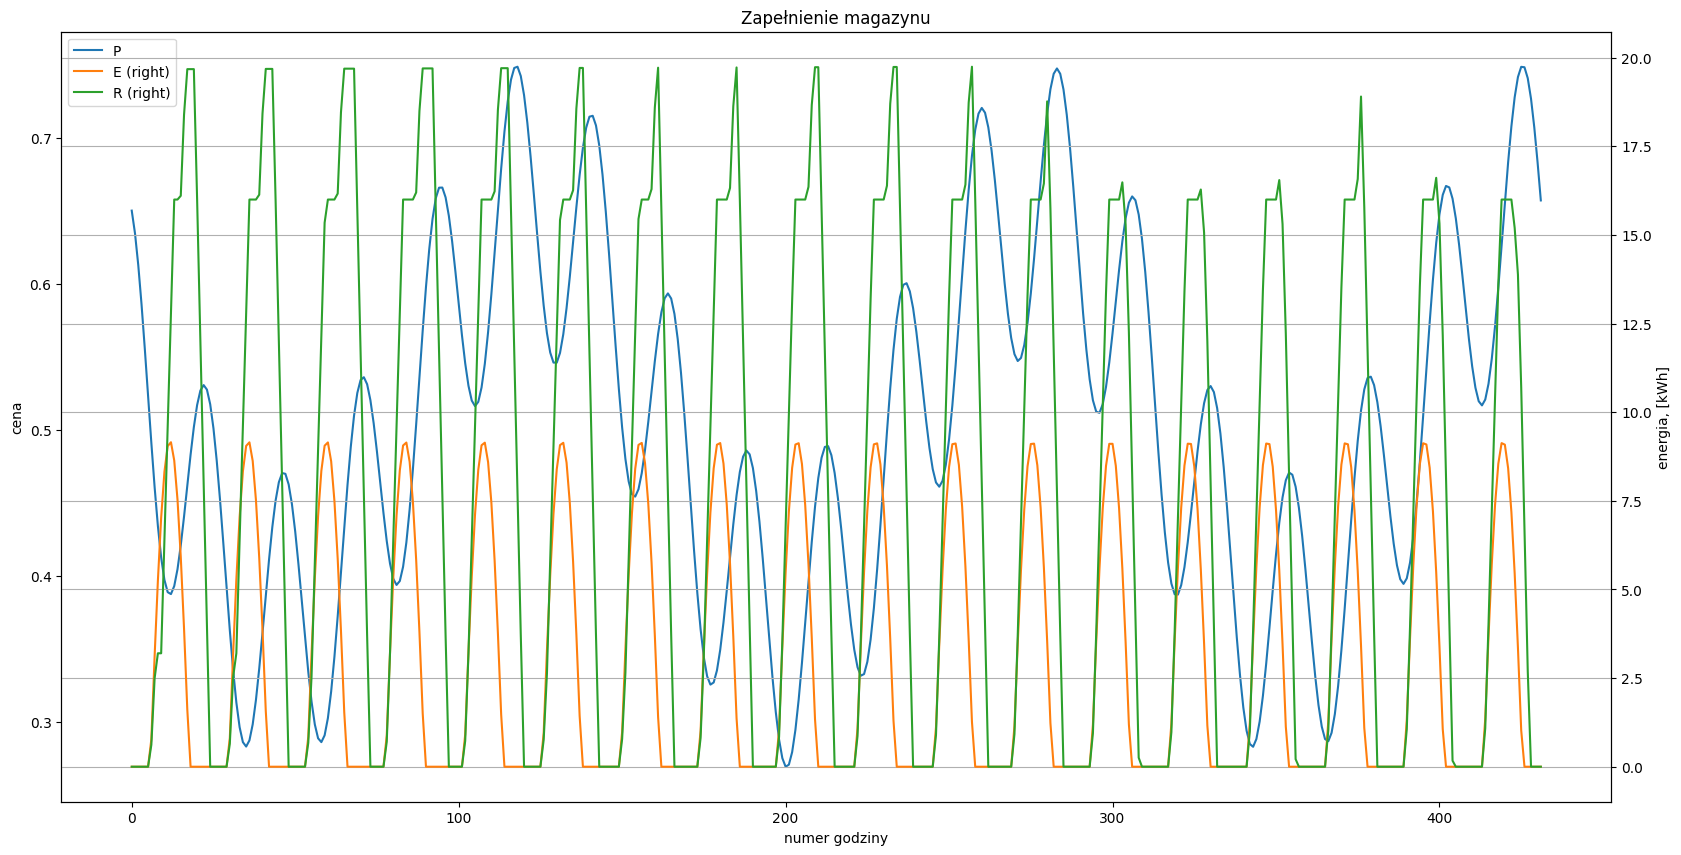

In [123]:
fig, ax = plt.subplots(figsize=(20,10))
ax = S.P.plot(ylabel="cena", legend=True)
ax = S.drop(columns=['P', 'D']).plot(grid=True, xlabel="numer godziny", ylabel='energia, [kWh]',
                            title = 'Zapełnienie magazynu', ax=ax, secondary_y=True, legend=True)
plt.show()

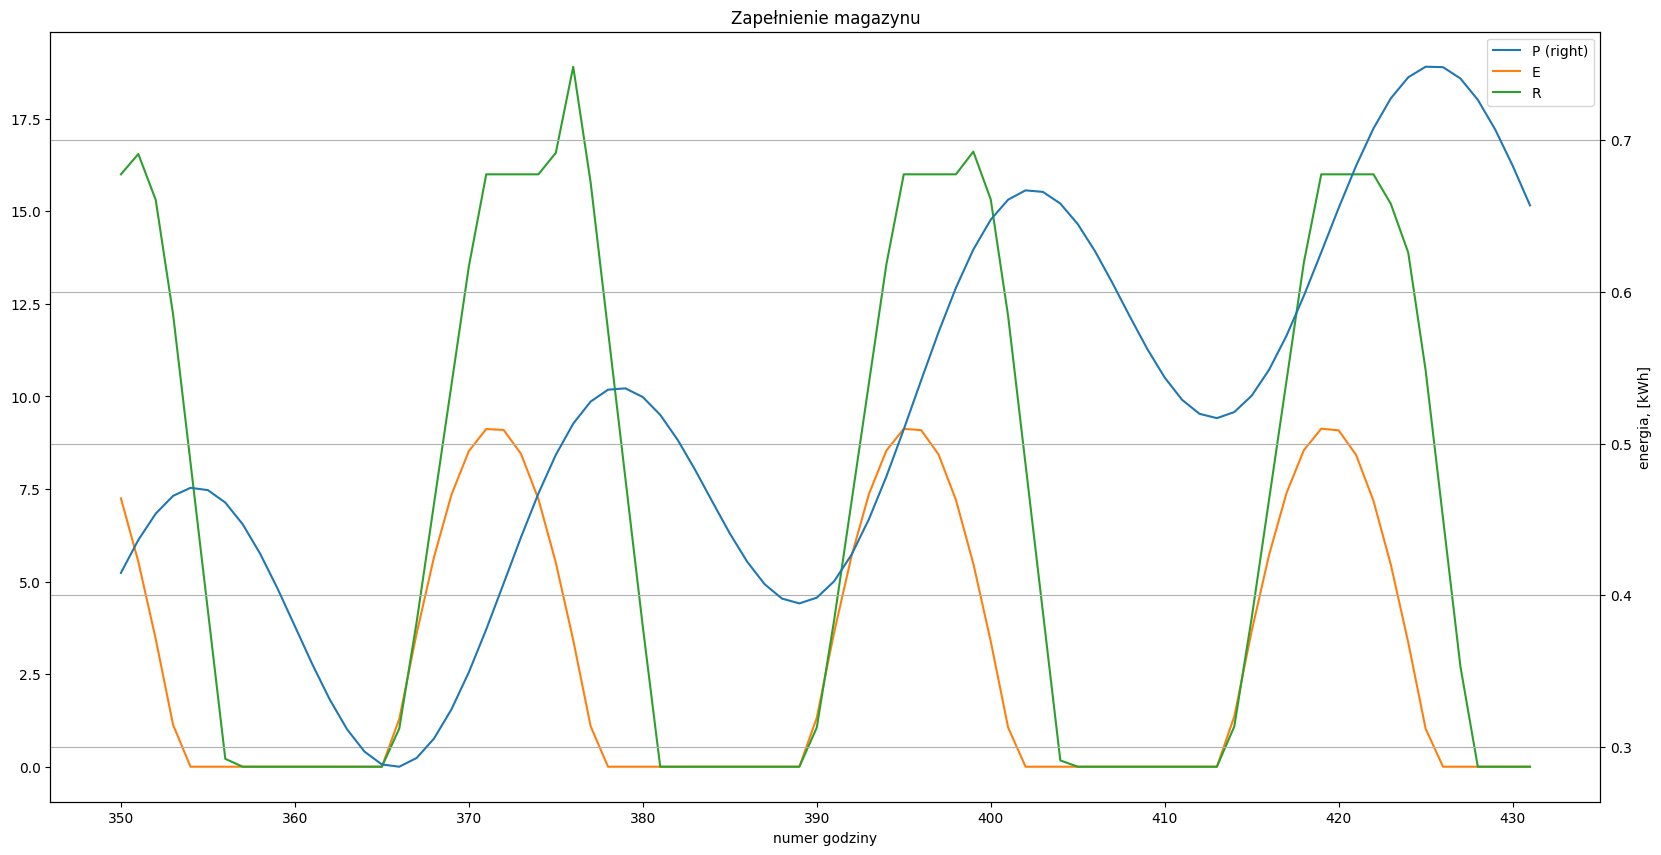

In [124]:
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1 = S.iloc[350:, ].drop(columns=['D']).plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]",
                            title = 'Zapełnienie magazynu', secondary_y=['P'], ax=ax1)

Kawałek poprzedniego wykresu, który zawiera około 5 dni. Widać, że każdy raż ładuje baterię, gdy ceny są najniższe (na przykład pomiędzy 360 i 370) i rozładowuje, gdy ceny są maksymalne (na przykład ok. 380). Ładuje powoli przez ograniczenia gc/gd.

### Stałe niezerowe zapotrzebowanie roczne

In [80]:
annual_demand = 50 * 10 ** 3
S_constant = S = pd.DataFrame({"P": price_func(t),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates)),
                  "D": demand(t, annual_demand)})
S.E = N * S.E

In [81]:
xs_constant_demand = solve(S_constant, Rc, nc, nd, gc, gd)

In [82]:
S_constant.R = xs_constant_demand.dot(phi).cumsum()

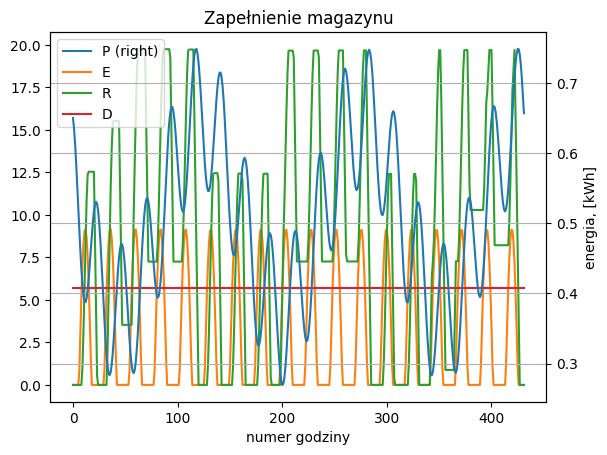

In [85]:
_ = S_constant.plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]",
                            title = 'Zapełnienie magazynu', secondary_y=['P'])

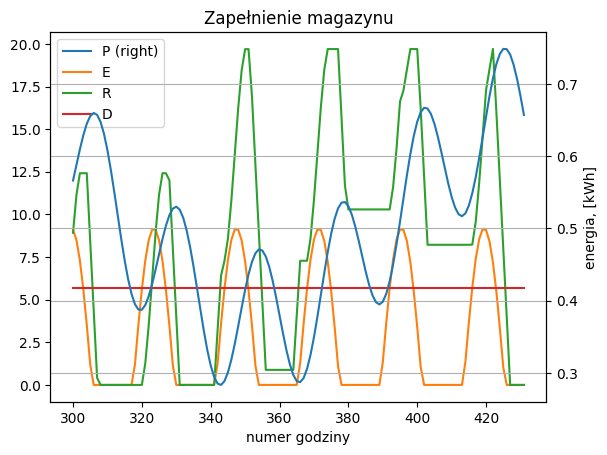

In [88]:
_ = S_constant.iloc[300:, ].plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]",
                            title = 'Zapełnienie magazynu', secondary_y=['P'])

Ponieważ teraz zapotrzebowanie jest niezerowe, to w odróżnieniu od pierwszego przypadku nie rozładowuje baterii całkowicie, gdy ceny zaczynają rosnąć po weekendzie. Przed weekendem rozłafowuje się całkowicie.

### Zapotrzebowanie - funkcja schodkowa

In [38]:
annual_demand = 50 * 10 ** 3
S_step = pd.DataFrame({"P": price_func(t),
                  "D": step_demand(t, dates, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})
S_step.E = N * S_step.E

In [39]:
xs_step_demand = solve(S_step, Rc, nc, nd, gc, gd)

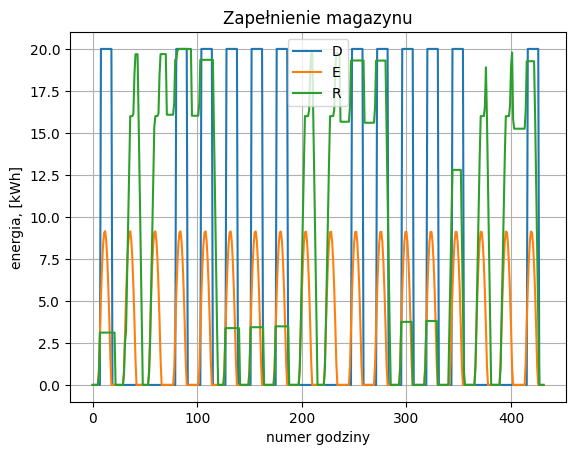

In [40]:
S_step.R = xs_step_demand.dot(phi).cumsum()
_ = S_step.\
    drop(columns=['P']).\
    plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]", title = 'Zapełnienie magazynu')

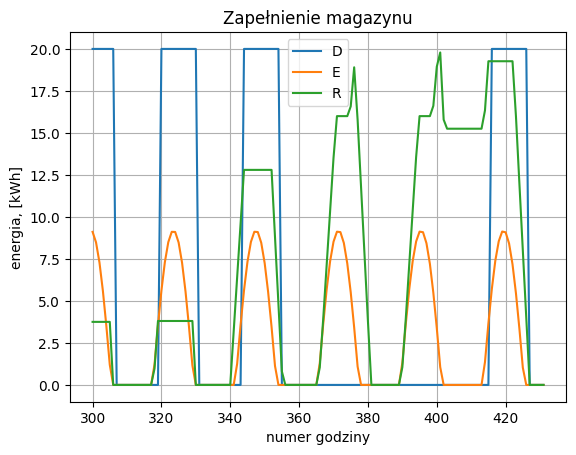

In [41]:
_ = S_step.drop(columns=['P']).\
        iloc[300:, ].\
        plot(grid=True, xlabel="numer godziny", ylabel="energia, [kWh]", title = 'Zapełnienie magazynu')

Bateria ładuje się do 100% tylko w weekend.

# Pieniądze

Gdyby nie było magazynu i fotowoltaiki, to koszt to demand * ceny. Wtedy w ciągu dwóch tygodni w ostatnim przypadku zapłacimy tyle:

In [125]:
expenses = np.dot(S_step.P, S_step.D)

In [126]:
expenses

1382.6456299287283

Dla przypadku z magazynem i fotowoltaiką

In [ ]:
phi_expenses = np.array([0, 1/nc, 0, 0, 1/nc, -1/nc])

In [128]:
expenses_photo = xs_step_demand.dot(phi).sum()

In [129]:
expenses_photo

3.019806626980426e-14